<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
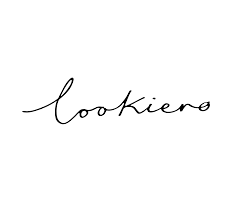    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Productos locomotores - Tendencias de marketing
En este script se detallarán los descriptivos obtenidos de este primer análisis. Tareas como detectar **cantidad de valores missing** o **outliers** entre otros.

### Carga de librerias 
---

- **General**

In [21]:
import pandas as pd
import glob
import os
import pickle 
import numpy as np
import itertools
from itertools import chain

def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df

- **Pyspark**

In [22]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import split, lit

* **Visualización**

In [23]:
import matplotlib.pyplot as plt

### Clases a utilizar
---

* Clase para **cargar de datos** (cd)

Se fijan los **directorios** de entrada y salida

In [24]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

In [25]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        path = os.getcwd()
        csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []

        for i in csv_files:
            temp_df = spark.read.csv(path = i, header = True, inferSchema = True)
            dataframes_list.append(temp_df)
        
        return dataframes_list
    
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return spark.read.csv(os.path.join(dir_in, nombre_tabla + ".csv"), header = True)

In [26]:
cd = carga_datos ()

### Datos a utlilizar
---

In [27]:
df_envios = abrir_pikle('df_envios')
df_indices = pd.read_csv(dir_out + 'df_indices.csv')
df_indices['prenda'] = df_indices['0'].apply(lambda x: x.split('_')[0])
df_indices.reset_index(inplace=True)

productos_finales = df_envios.merge(df_indices, left_on='id_variant', right_on='0')
productos_finales['tasa_aceptacion'] = productos_finales['ventas']/productos_finales['envios']
productos_finales.sort_values(by=['index'], ascending=True, inplace=True)
productos_finales.fillna(0, inplace=True)
productos_finales['season'] = productos_finales['id_variant'].apply(lambda x: x.split('_')[3])

In [28]:
looks_array_G7 = abrir_pikle('looks_array_G7')
looks_array_G8 = abrir_pikle('looks_array_G8')
looks_array_G9 = abrir_pikle('looks_array_G9')

G7 = abrir_pikle('G7')
G8 = abrir_pikle('G8')
G9 = abrir_pikle('G9')

### Prendas más influyentes en los looks
---

In [29]:
def printer_resultadoo(look):
    lista_looks = list(chain.from_iterable(look[:,1]))
    pos = np.argmax(np.unique(lista_looks, return_counts=True)[1])
    value = np.max(np.unique(lista_looks, return_counts=True)[1])
    print('===========================')
    print(len(look))
    print('%%%',len(look) / value)
    print(df_indices.iloc[ np.unique(lista_looks, return_counts=True)[0][pos]  ,:].values)
    return len(look) / value
    
percentaje7 = printer_resultadoo(looks_array_G7)
percentaje8 = printer_resultadoo(looks_array_G8)
percentaje9 = printer_resultadoo(looks_array_G9)

367636
%%% 5.128492711166911
[16389 'pant_bluedark_XS_7_classic_smooth_NOPREMIUM' 'pant']
457339
%%% 5.345368054419224
[5 'jacket_grey_S_8_classic.minimal_smooth_NOPREMIUM' 'jacket']
479199
%%% 4.067454355631382
[16384 'sweatshirt_bluedark_XS_9_casual.street_smooth_NOPREMIUM'
 'sweatshirt']


### Prendas sobre las que más se influye
---

In [30]:
indices = list(productos_finales[productos_finales['season']=='7'].sort_values(by=['ventas'], ascending=False).head(20)['index'])
vecinos = [list(G7.neighbors(x)) for x in indices]
vecinos = list(chain.from_iterable(vecinos))
pos = np.argmax(np.unique(vecinos, return_counts=True)[1])
value = np.max(np.unique(vecinos, return_counts=True)[1])

vecinos_popualares = pd.DataFrame(np.unique(vecinos, return_counts=True)[0])
vecinos_popualares['count'] = np.unique(vecinos, return_counts=True)[1]

lista_vecinos_de_top = list(vecinos_popualares.sort_values(by=['count'], ascending=False)[0][1:4].values)
lista_vecinos_de_top = [int(x) for x in lista_vecinos_de_top]

productos_finales.iloc[lista_vecinos_de_top,]

,id_variant,envios,ventas,index,0,prenda,tasa_aceptacion,season
9704,top_ecru_XS_7_boho_smooth_NOPREMIUM,254320,104456,9730,top_ecru_XS_7_boho_smooth_NOPREMIUM,top,0.410727,7
9827,tshirt_ecru_S_7_casual.classic_smooth_NOPREMIUM,228096,101376,9853,tshirt_ecru_S_7_casual.classic_smooth_NOPREMIUM,tshirt,0.444444,7
9817,cardigan_orange_M_7_boho.classic_smooth_NOPREMIUM,300058,143506,9843,cardigan_orange_M_7_boho.classic_smooth_NOPREMIUM,cardigan,0.478261,7


In [36]:
percentaje = [percentaje7, percentaje8, percentaje9]
axis = ['Verano','Invierno','Primevera-Otoño']
colores = ['#264653','#85CAC2','#E76F51']

### Reprensetación de los datos
---

C:\Users\Daniel\AppData\Local\Temp/ipykernel_2688/3454547513.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


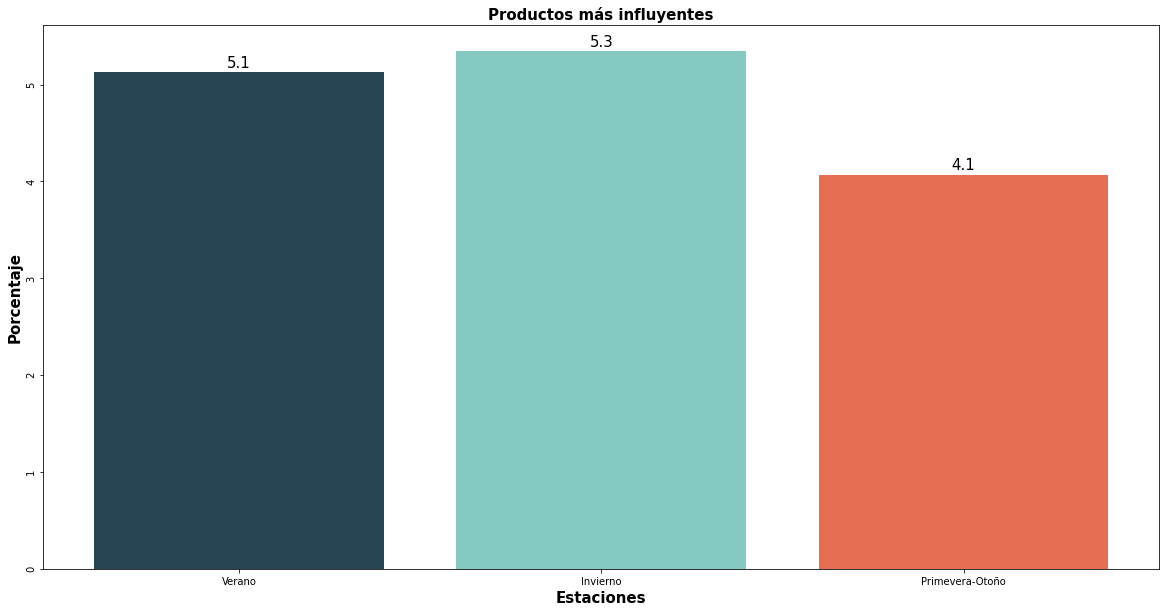

In [37]:

fig, ax = plt.subplots(figsize = (20, 10))
ax.bar(axis, percentaje, color = colores)

ax.set_title(f'Productos más influyentes', color = 'k', weight = 'bold', fontsize = 15)
ax.set_xlabel('Estaciones', color = 'k', weight = 'bold', fontsize = 15) 
ax.set_ylabel('Porcentaje', color = 'k', weight = 'bold', fontsize = 15)

plt.yticks(rotation=90)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=15)
fig.show()

---